# Fit halo mass to shear profile using Numcosmo statistical framework

_the LSST-DESC CLMM team_

This notebook is used to make Fig.4 of the CLMM v1.0 paper and is a shortened version of the `Example2_Fit_Halo_Mass_to_Shear_Catalog.ipynb` notebook. Please refer to the `Example2` notebook for more details.

NB: to display the corner plot output of the MCMC analysis, you will need the `corner` package installed in your python environment.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import sys
import gi

gi.require_version("NumCosmo", "1.0")
gi.require_version("NumCosmoMath", "1.0")
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from scipy.stats import chi2

import math

# The corner package is needed to view the results of the MCMC analysis
import corner


os.environ["CLMM_MODELING_BACKEND"] = "nc"

__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
import clmm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from numpy import random
from clmm.support.sampler import fitters

clmm.__version__

'0.9.2'

Next, we import `clmm`'s core modules.

In [3]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [4]:
from clmm.support import mock_data as mock

## Making mock data

For reproducibility:

In [5]:
np.random.seed(12)

To create mock data, we need to define a true cosmology.

In [6]:
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

We now set some parameters for a mock galaxy cluster.

In [7]:
cosmo = mock_cosmo
cluster_m = 1.0e15  # M200,m [Msun]
cluster_z = 0.3  # Cluster's redshift
concentration = 4
ngals = 10000  # Number of galaxies
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a background galaxy catalog, with galaxies distributed in redshift according to the Chang et al. (2013) parametrisation, and that includes (a low level of) shape noise and photoz errors.

In [8]:
noisy_data_z = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    "chang13",
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals,
)

/pbs/home/c/ccombet/.conda/envs/mydesc2/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)
/pbs/home/c/ccombet/.conda/envs/mydesc2/lib/python3.7/site-packages/clmm-0.9.2-py3.7.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.


The galaxy catalog table is used to instatiate a `clmm.GalaxyCluster` object and is stored in the `galcat` attribute.

In [9]:
cluster_id = "CL"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, noisy_data_z)
gc_object.save("noisy_GC_z.pkl")

In [10]:
cl = clmm.GalaxyCluster.load("noisy_GC_z.pkl")

print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: CL ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


## Deriving observables

### Computing shear

`clmm.dataops.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster object and adds the corresponding columns to the `galcat` table.

In [11]:
cl.compute_tangential_and_cross_components(geometry="flat");

### Radially binning the data

In [12]:
bin_edges = da.make_bins(0.7, 4, 15, method="evenlog10width")

`clmm.dataops.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [13]:
cl.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo);

After running `clmm.dataops.make_radial_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [14]:
for n in cl.profile.colnames:
    cl.profile[n].format = "%6.3e"
cl.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.444e-01  7.863e-01 5.081e-02 6.660e-03 -5.816e-03 5.980e-03 1.332e+00 8.891e-02 6.800e+01
 7.863e-01 8.279e-01  8.831e-01 5.100e-02 5.473e-03  1.377e-03 6.264e-03 1.282e+00 8.046e-02 8.100e+01
 8.831e-01 9.368e-01  9.920e-01 3.660e-02 4.780e-03  3.737e-03 5.256e-03 1.198e+00 5.481e-02 9.700e+01
 9.920e-01 1.052e+00  1.114e+00 4.112e-02 4.008e-03  3.605e-03 4.675e-03 1.365e+00 6.908e-02 1.410e+02
 1.114e+00 1.190e+00  1.251e+00 3.575e-02 3.965e-03 -6.299e-05 3.995e-03 1.252e+00 5.140e-02 1.630e+02
 1.251e+00 1.333e+00  1.406e+00 3.318e-02 3.482e-03 -3.737e-03 3.390e-03 1.314e+00 5.475e-02 2.150e+02
 1.406e+00 1.496e+00  1.579e+00 2.710e-02 3.076e-03  3.924e-04 2.825e-03 1.259e+00 4.313e-02 2.610e+02
 1.579e+00 1.678e+00  1.773e+00 2.333e-02 2.846e-03  1.234e-03 2.866e-03 

Text(0, 0.5, '$g_t$')

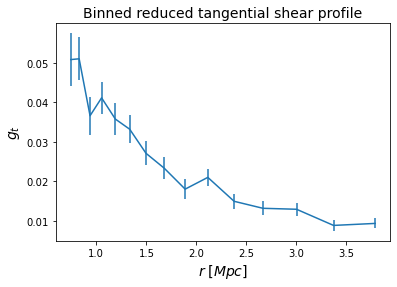

In [15]:
fsize = 14
plt.errorbar(cl.profile["radius"], cl.profile["gt"], yerr=cl.profile["gt_err"])

plt.title(r"Binned reduced tangential shear profile", fontsize=fsize)
plt.xlabel(r"$r\;[Mpc]$", fontsize=fsize)
plt.ylabel(r"$g_t$", fontsize=fsize)

## Fitting a halo mass - highlighting bias when NOT accounting for the source redshift distribution in the model

We estimate the best-fit mass using a simple implementation of the likelihood using a NcmDataGaussDiag object.

Here, to build the model we purposely make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This will yield a bias in the reconstructed mass where the sources followed the Chang et al. (2013) distribution.

The CLMM theory object-oriented interface is used to build the model and we also use NumCosmo statistical framework to perform the analysis. Below we create an object based on NumCosmo NcmDataGaussDiag (Gaussian likelihood with a diagonal covariance matrix) object. To connect with the C interface of NumCosmo the object must implement the methods: `do_get_length`, `do_get_dof`, `do_begin`, `do_prepare` and `do_mean_func`. The last method is responsible to compute the theoretical predictions. In the `param_set_ftype` calls below, one can change between FREE/FIXED to include/exclude the parameter from the analysis. 

In [16]:
class GaussGammaTErr(Ncm.DataGaussDiag):
    z_cluster = GObject.Property(type=float, flags=GObject.PARAM_READWRITE)
    z_source = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    r_source = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)
    z_err = GObject.Property(type=Ncm.Vector, flags=GObject.PARAM_READWRITE)

    def __init__(self):
        Ncm.DataGaussDiag.__init__(self, n_points=0)
        self.moo = clmm.Modeling()

    def init_from_data(
        self, z_cluster, r_source, z_source, gt_profile, gt_err, z_err=None, moo=None
    ):
        if moo:
            self.moo = moo

        assert len(gt_profile) == len(z_source)
        assert len(gt_profile) == len(r_source)
        assert len(gt_profile) == len(gt_err)

        self.set_size(len(gt_profile))

        self.props.z_cluster = z_cluster
        self.props.z_source = Ncm.Vector.new_array(z_source)
        self.props.r_source = Ncm.Vector.new_array(r_source)
        if z_err:
            self.props.r_source = Ncm.Vector.new_array(z_err)

        self.y.set_array(gt_profile)

        self.sigma.set_array(
            gt_err
        )  # Diagonal covariance matrix: standard deviation values in gt_err.

        self.set_init(True)

    # Once the NcmDataGaussDiag is initialized, its parent class variable np is set with the n_points value.
    def do_get_length(self):
        return self.np

    def do_get_dof(self):
        return self.np

    def do_begin(self):
        pass

    def do_prepare(self, mset):
        self.moo.set_mset(mset)

    def do_mean_func(self, mset, vp):
        vp.set_array(
            self.moo.eval_reduced_tangential_shear(
                self.props.r_source.dup_array(),
                self.props.z_cluster,
                self.props.z_source.dup_array(),
            )
        )
        return


GObject.type_register(GaussGammaTErr)

NcContext.GaussGammaTErr

Defining the model set (NcmMset), data set (NcmDataset) and NcmLikelihood objects to carry out a statistical analysis. 

The method `param_set_ftype` defines the parameters that can be fitted: `mid` - to which model set the parameter belongs to, `pid` - parameters' id, NcmParamType (FREE or FIXED) to say if the parameter will be fitted or not.

In [17]:
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")
moo.set_cosmo(cosmo)

ggt = GaussGammaTErr()

ggt.init_from_data(
    z_cluster=cluster_z,
    r_source=cl.profile["radius"],
    z_source=cl.profile["z"],
    gt_profile=cl.profile["gt"],
    gt_err=cl.profile["gt_err"],
    moo=moo,
)

mset = ggt.moo.get_mset()

# Parameters: cluster mass (log base 10) and concentration
MDelta_pi = mset.param_get_by_full_name("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset.param_get_by_full_name("NcHaloDensityProfile:cDelta")

mset.param_set_ftype(MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype(cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map()

dset = Ncm.Dataset.new()
dset.append_data(ggt)
lh = Ncm.Likelihood.new(dset)

### Fitting parameters: Fisher Matrix

The NcmFit object receives the NcmLikelihood and NcmMset objects. The user also indicates the fitting algorithm and the numerical differentiation method.  
Functions `run` and `fisher` computes the [best-fit](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) and the [fisher matrix](https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution), respectively. `log_info` prints the complete information about the data used, models and its parameters, and `log_covar` prints the best-fit along with the error-bar and the covariance matrix.

In [18]:
fit = Ncm.Fit.new(Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.fisher()
fit.log_info()
fit.log_covar()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0224380
#  iteration            [000074]
#  function evaluations [000076]
#  gradient evaluations [000000]
#  degrees of freedom   [000013]
#  m2lnL     =     7.58698159049399 (     7.5869816 )
#  Fit parameters:
#     4.77766142572725     14.9174380372699    
#----------------------------------------------------------------------------------
# Data used:
#   - NcContext+GaussGammaTErr
#----------------------------------------------------------------------------------
# Model[01000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model par

With this 'wrong' model, the best-fit mass is biased low:

In [19]:
m_est = 10 ** mset.param_get(MDelta_pi.mid, MDelta_pi.pid)
m_est_err = fit.covar_sd(MDelta_pi.mid, MDelta_pi.pid) * m_est * math.log(10.0)

print(r"M = % 22.15e +/- %.0e M$_\odot$" % (m_est, m_est_err))

M =  8.268715267041262e+14 +/- 5e+13 M$_\odot$


### To investigate the result further we use the MCMC analysis below.

We begin by specifying if the run is single- or multi-thread: `func_eval_set_max_threads` sets the maximum number of threads, and `func_eval_log_pool_stats` prints the information about the thread pool.

Then, we initialize the transition kernel object (NcmMSetTransKern) which defines the distribution of the initial points of the parameter space to be used by the ensemble sampler. In this example we use the Gaussian transition kernel (NcmMSetTransKernGauss), with priors provided by the NcmMset (`set_prior_from_mset`). `set_cov_from_rescale` sets the covariance matrix with zero correlation and the diagonal terms defined by the scale of each parameter times the argument of `set_cov_from_rescale`. 

Here we use the Ensemble Sampler MCMC (ESMCMC) method. `nwalkers` and `walker` define the number of walkers and the algorithm used to move the points in the ensemble. 
Running: `start_run`, `run_lre` and `end_run`. `run_lre` runs the ESMCMC until the relative error of the mean of each parameter is smaller than $10^{-3}$. Its first argument (integer) indicates how many ensembles are computed before applying any convergence test.

In the end we save the catalog to mcat_wrong to compare with a correct analysis.

In [20]:
Ncm.func_eval_set_max_threads(0)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0e-1)

nwalkers = 100  # Number of walkers
walker = Ncm.FitESMCMCWalkerAPS.new(nwalkers, mset.fparams_len())

# Ensemble Sampler MCMC
esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file("fig4_fit_wrong_esmcmc_out_aps.fits")
esmcmc.set_auto_trim(True)  # Detect and discard the burn-in points.
esmcmc.set_auto_trim_div(100)
esmcmc.set_max_runs_time(2.0 * 60.0)  # Maximum time between tests.

esmcmc.start_run()
esmcmc.run_lre(20, 1.0e-2)
esmcmc.end_run()

mcat_wrong = esmcmc.peek_catalog()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      0
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1884186431.
# NcmMSetCatalog: Current mean:   13.852       4.7774       14.924     
# NcmMSetCatalog: Current msd:    1.0259       0.0011498    0.0046271  
# NcmMSetCatalog: Current sd:     10.259       0.011498     0.046271   
# NcmMSetCatalog: Current var:    105.24       0.0001322    0.002141   
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------

## Fitting the cluster mass and concentration : using an unbinned analysis

Here, instead of building an object directly on top of NcmDataGauss*, we use NumCosmo's framework to build non-binned likelihood for weak-lensing cluster analysis.

For that we need two objects: a NcGalaxyWLReducedShearGauss that model a Gaussian distributed reduced shear likelihood, here the observables matrix is simply $(r, \gamma_t, \sigma_{\gamma_t})$ for each galaxy. If the data has spectroscopic redshifts then we use NcGalaxyRedshiftSpec with an array of real redshifts. When photometric errors are included we use the NcGalaxyRedshiftGauss object that receives $(z, \sigma_z)$ for each galaxy. 

Once we have the data objects ready we can proceed as in the previous examples.


In [21]:
def create_nc_data_cluster_wl(
    theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z=None, sigma_g=None
):
    r = clmm.convert_units(theta, "radians", "Mpc", redshift=z_cluster, cosmo=cosmo)
    ga = Ncm.ObjArray.new()

    sigma_g = 1.0e-4 if not sigma_g else sigma_g
    m_obs = np.column_stack((r, g_t, np.repeat(sigma_g, len(r))))

    grsg = Nc.GalaxyWLReducedShearGauss(pos=Nc.GalaxyWLReducedShearGaussPos.R)
    grsg.set_obs(Ncm.Matrix.new_array(m_obs.flatten(), 3))

    if sigma_z:
        gzgs = Nc.GalaxyRedshiftGauss()
        z_obs = np.column_stack((z_source, (1.0 + z_source) * sigma_z))
        gzgs.set_obs(Ncm.Matrix.new_array(z_obs.flatten(), 2))
    else:
        gzgs = Nc.GalaxyRedshiftSpec()
        gzgs.set_z(Ncm.Vector.new_array(z_source))

    gwl = Nc.GalaxyWL(wl_dist=grsg, gz_dist=gzgs)
    ga.add(gwl)

    nc_dcwl = Nc.DataClusterWL(galaxy_array=ga, z_cluster=z_cluster)
    nc_dcwl.set_init(True)

    return nc_dcwl


def create_fit_obj(data_array, mset):
    dset = Ncm.Dataset.new()
    for data in data_array:
        dset.append_data(data)
    lh = Ncm.Likelihood.new(dset)
    fit = Ncm.Fit.new(Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)
    # fit.set_params_reltol (1.0e-8)
    # fit.set_m2lnL_reltol (1.0e-11)

    return fit

In [22]:
ggt = create_nc_data_cluster_wl(
    cl.galcat["theta"],
    cl.galcat["et"],
    cl.galcat["z"],
    cluster_z,
    cosmo,
    cosmo.dist,
    sigma_z=0.05,
    sigma_g=0.05,
)

### As the likelihood is not Gaussian, here we compute the [Observed Fisher Matrix](https://en.wikipedia.org/wiki/Observed_information) (`obs_fisher`).

In [23]:
fit = create_fit_obj([ggt], mset)
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher()
fit.log_covar()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:09.4158630
#  iteration            [000049]
#  function evaluations [000051]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =     10018.6239250892 (     10018.624 )
#  Fit parameters:
#     3.97653148613195     14.996804406858     
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                       -------------------------------
#      cDelta[04000:00] =  3.977       +/-  0.1884      |  1           | -0.6633      |
# log10MDelta[04000:01] =  15          +/-  0.02187     | -0.6633      |  1           |

With the unbinned likelihood, the bestfit mass is not biased low anymore

In [24]:
m_est = 10 ** mset.param_get(MDelta_pi.mid, MDelta_pi.pid)
m_est_err = fit.covar_sd(MDelta_pi.mid, MDelta_pi.pid) * m_est * math.log(10.0)

print(r"M = % 22.15e +/- %.0e M$_\odot$" % (m_est, m_est_err))

M =  9.926688795953281e+14 +/- 5e+13 M$_\odot$


### As with the wrong model before, we investigate the results further with the MCMC analysis below. Depending on your machine, the next cell will take 15-30 min to run

In [25]:
Ncm.func_eval_set_max_threads(0)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0e-1)

nwalkers = 100
stretch = Ncm.FitESMCMCWalkerAPS.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_data_file("fig4_fit_esmcmc_out_aps.fits")
esmcmc.set_auto_trim(True)
esmcmc.set_auto_trim_div(100)
esmcmc.set_max_runs_time(2.0 * 60.0)

esmcmc.start_run()
esmcmc.run_lre(20, 1.0e-3)
esmcmc.end_run()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      0
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensamble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0100.
#   Number of threads: 0000.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 3170357068.
# NcmMSetCatalog: Current mean:   10028        3.9778       15.004     
# NcmMSetCatalog: Current msd:    1.3168       0.00087633   0.0048539  
# NcmMSetCatalog: Current sd:     13.168       0.0087633    0.048539   
# NcmMSetCatalog: Current var:    173.4        7.6796e-05   0.002356   
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------

## Visualization of the results:  below we plot the results of both MCMC

The wrong analysis (blue) has a strong bias in $\log_{10}(M_\Delta)$. The peak with the wrong model is more than $3\sigma$ away from the input values (green lines). The "correct" model used in the unbinned analysis (purple) yield results in agreement with the truth and has a much smaller variance.

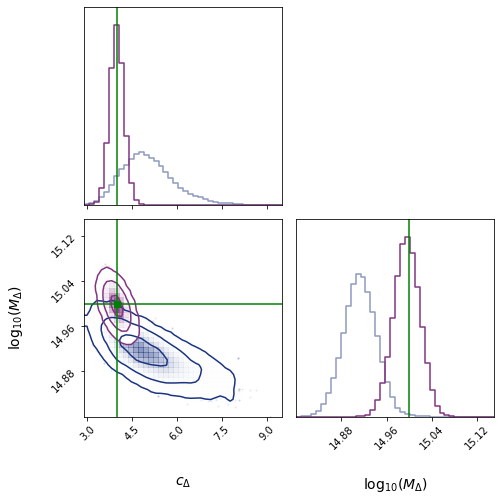

In [26]:
s2d1 = chi2.cdf(1.0, df=2)
s2d2 = chi2.cdf(4.0, df=2)
s2d3 = chi2.cdf(9.0, df=2)


rows = np.array(
    [mcat_wrong.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat_wrong.len())]
)
params = ["$" + mcat_wrong.col_symb(i) + "$" for i in range(mcat_wrong.ncols())]
figure = corner.corner(
    rows[:, 1:],
    labels=params[1:],  # range=[(2.9, 9.5), (14.8, 15.12)],
    color=(0.1, 0.2, 0.5, 0.5),
    levels=(s2d1, s2d2, s2d3),
    bins=40,
    smooth=0.8,
    smooth1d=0.8,
    range=[(2.9, 9.5), (14.8, 15.15)],
)

mcat = esmcmc.peek_catalog()
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range(mcat.ncols())]
corner.corner(
    rows[:, 1:],
    labels=params[1:],  # reverse = False,
    truths=(4, 15),
    truth_color="green",
    levels=(s2d1, s2d2, s2d3),
    bins=40,
    smooth=0.8,
    smooth1d=0.8,
    color=(0.5, 0.2, 0.5, 1.0),
    label_kwargs=dict(fontsize=fsize),
    range=[(2.9, 9.5), (14.8, 15.15)],
    fig=figure,
)

figure.set_size_inches(7, 7)
figure.tight_layout()
plt.savefig("Fig4.pdf")

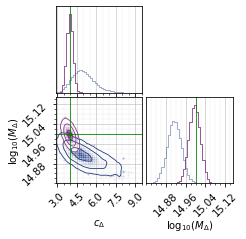

In [27]:
s2d1 = chi2.cdf(1.0, df=2)
s2d2 = chi2.cdf(4.0, df=2)
s2d3 = chi2.cdf(9.0, df=2)


rows = np.array(
    [mcat_wrong.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat_wrong.len())]
)
params = ["$" + mcat_wrong.col_symb(i) + "$" for i in range(mcat_wrong.ncols())]
figure = corner.corner(
    rows[:, 1:],
    labels=params[1:],  # range=[(2.9, 9.5), (14.8, 15.12)],
    color=(0.1, 0.2, 0.5, 0.5),
    levels=(s2d1, s2d2, s2d3),
    bins=40,
    smooth=0.8,
    smooth1d=0.8,
    range=[(2.9, 9.5), (14.8, 15.15)],
    hist_kwargs={"lw": 0.8},
)

mcat = esmcmc.peek_catalog()
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range(mcat.ncols())]
corner.corner(
    rows[:, 1:],
    labels=params[1:],  # reverse = False,
    truths=(4, 15),
    truth_color="green",
    levels=(s2d1, s2d2, s2d3),
    bins=40,
    smooth=0.8,
    smooth1d=0.8,
    color=(0.5, 0.2, 0.5, 1.0),
    label_kwargs=dict(fontsize=10),
    range=[(2.9, 9.5), (14.8, 15.15)],
    hist_kwargs={"lw": 0.8},
    fig=figure,
)

figure.set_size_inches(8 / 2.54, 8 / 2.54)

axes = figure.axes
for ax in axes:
    ax.xaxis.grid(True, which="major", lw=0.5)
    ax.yaxis.grid(True, which="major", lw=0.5)
    ax.xaxis.grid(True, which="minor", lw=0.1)
    ax.yaxis.grid(True, which="minor", lw=0.1)
for ax in (axes[0], axes[2]):
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
axes[2].yaxis.set_minor_locator(MultipleLocator(0.02))
axes[3].xaxis.set_minor_locator(MultipleLocator(0.02))

axes[2].yaxis.set_label_coords(-0.4, 0.5)
axes[2].xaxis.set_label_coords(0.5, -0.4)
axes[3].xaxis.set_label_coords(0.5, -0.4)

for ax in axes:
    for col in ax.collections:
        col.set_linewidth(0.8)
    for line in ax.lines:
        line.set_linewidth(0.8)
        line.set_markersize(2)

figure.subplots_adjust(left=0.2, bottom=0.2, right=0.98, top=0.98)
figure.savefig("Fig4.png", dpi=300)

In [28]:
ser = Ncm.Serialize.new(0)
data = fit.lh.dset.get_data(0)
ser.to_file(data, "Fig4_data.obj")